In [50]:
using Pkg; Pkg.activate(".")
using CSV
using DataFrames
using PyPlot
using LaTeXStrings
using MUST
using DelimitedFiles
using Statistics
using Polynomials
MUST.@import_dispatch "../../../dispatch2"

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/running_dispatch/Project.toml`


PyObject <module 'dispatch' from '/cobra/ptmp/peitner/model_grid/dispatch2/utilities/python/dispatch/__init__.py'>

In [51]:
results = DataFrame(CSV.File("summary_testrun3.csv"));

In [52]:
t, rho, ee0, ee_min, successP1, successP2 = eachcol(results[:,[:stellar_params!tt_k, :stellar_params!d_cgs, :newton_params!ee0, :stellar_params!ee_min, :phase1_success, :phase2_success]]);

# Phase 1 (no RT)

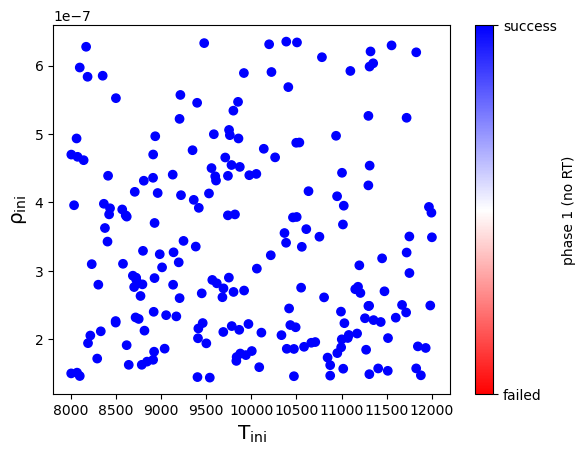

In [53]:
plt.close()
im = plt.scatter(t, rho, c=successP1, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 1 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
#plt.savefig("t_rho_p1_success.png")

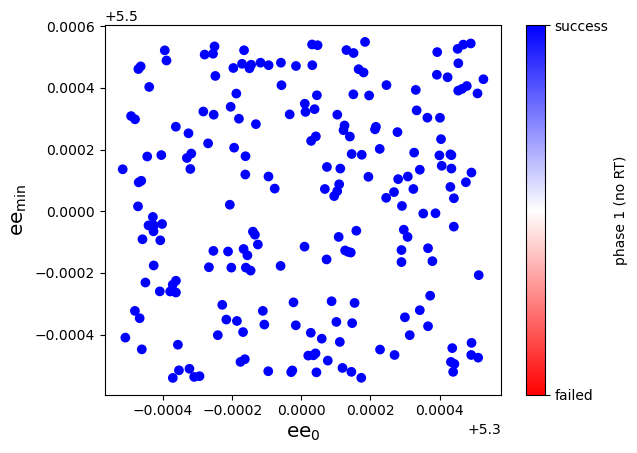

In [54]:
plt.close()
im = plt.scatter(ee0, ee_min, c=successP1, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm ee_{0}", fontsize="x-large")
plt.ylabel(L"\rm ee_{min}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 1 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("ee0_eemin_p1_success.png")

# Phase 2 (with RT)

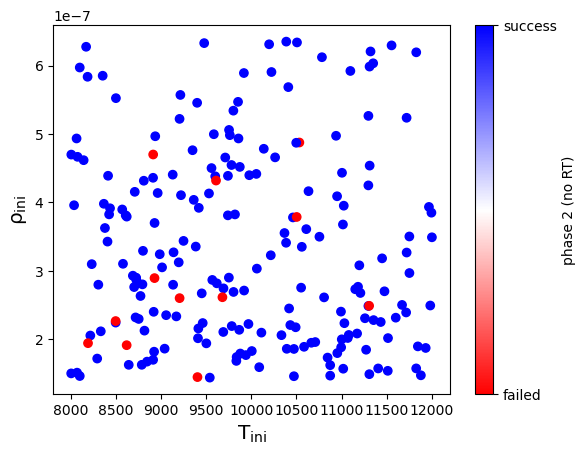

In [55]:
plt.close()
im = plt.scatter(t, rho, c=successP2, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 2 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("t_rho_p2_success.png")

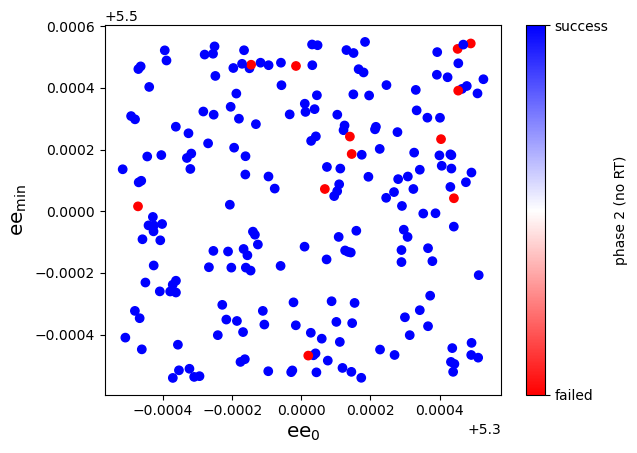

In [56]:
plt.close()
im = plt.scatter(ee0, ee_min, c=successP2, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm ee_{0}", fontsize="x-large")
plt.ylabel(L"\rm ee_{min}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 2 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("ee0_eemin_p2_success.png")

# Effective temperature of successful runs

In [57]:
get_teff(folder) = begin
    path = joinpath(folder, "teff.dat")
    if !ispath(path) @warn "$(path) does not exist."
        return nothing
    end
    data = readdlm(path)
end 

get_teff (generic function with 1 method)

In [58]:
folders = [@MUST.in_dispatch(joinpath("data_testrun3",r[1:first(findfirst(".nml",r))-1])) for r in results[results.phase2_success .== true, :phase2_name]];

In [59]:
teff = [get_teff(f) for f in folders];

┌ Warning: /cobra/ptmp/peitner/model_grid/dispatch2/experiments/stellar_atmospheres/data_testrun3/grid110_phase2/teff.dat does not exist.
└ @ Main In[57]:3
┌ Warning: /cobra/ptmp/peitner/model_grid/dispatch2/experiments/stellar_atmospheres/data_testrun3/grid157_phase2/teff.dat does not exist.
└ @ Main In[57]:3
┌ Warning: /cobra/ptmp/peitner/model_grid/dispatch2/experiments/stellar_atmospheres/data_testrun3/grid174_phase2/teff.dat does not exist.
└ @ Main In[57]:3


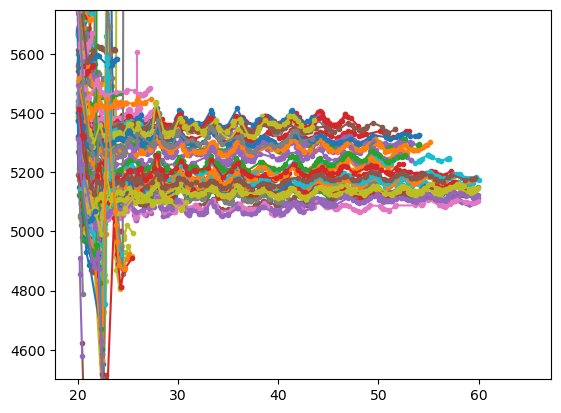

In [60]:
plt.close()
for r in teff
    isnothing(r) && continue
    
    plt.plot(r[:,1], r[:,2], marker=".")
end
plt.ylim(4500,5750)
plt.savefig("teff.png")

In [61]:
teff_t = Float64[]
for t in teff
    try
        isnothing(t) ? append!(teff_t, [NaN]) : append!(teff_t, [mean(t[end-20:end,2])])
    catch
        append!(teff_t, [NaN])
    end
end


size(teff_t)

(198,)

In [62]:
t_success, rho_success = eachcol(results[results.phase2_success .== true, [:stellar_params!tt_k, :stellar_params!d_cgs]]);

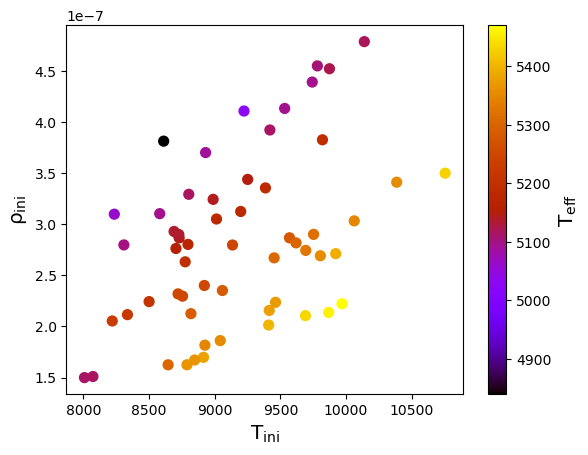

In [63]:
plt.close()
im = plt.scatter(t_success, rho_success, c=teff_t, cmap="gnuplot", s=50)
cbar = plt.colorbar(im)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar.set_label(L"\rm T_{eff}", fontsize="x-large")
plt.savefig("t_rho_teff.png")

In [99]:
function get_initial(t_success, rho_success, teff; goal=5778.0)
    mask = .!isnan.(teff)
    linfit_t   = Polynomials.fit(t_success[mask], teff[mask], 1)
    linfit_rho = Polynomials.fit(log.(rho_success[mask]), teff[mask], 1)
    
    t_ini   = (goal - linfit_t.coeffs[1])/linfit_t.coeffs[2]
    rho_ini = (goal - linfit_rho.coeffs[1])/linfit_rho.coeffs[2]

    (t_ini, exp(rho_ini))
end

get_initial (generic function with 1 method)

In [100]:
get_initial(t_success, rho_success, teff_t)

(14940.443588092769, 2.6138129873767868e-8)

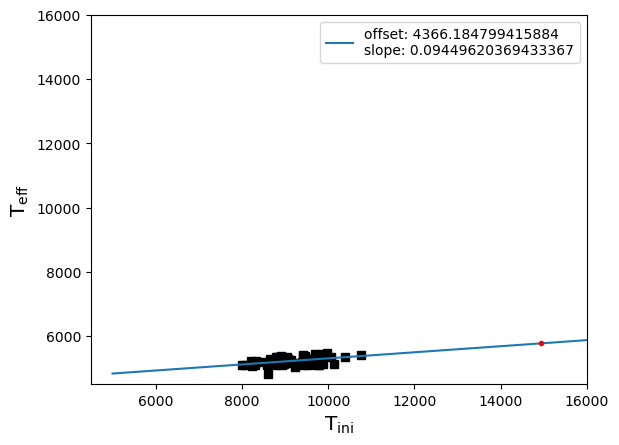

PyObject <matplotlib.legend.Legend object at 0x2b0fca326a00>

In [102]:
plt.plot(t_success, teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(t_success[mask], teff_t[mask], 1)
x = [5000:100:16000...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(4500,16000)
plt.ylim(4500,16000)

plt.plot([get_initial(t_success, rho_success, teff_t)[1]],[5778], color="red", marker=".")

plt.legend()

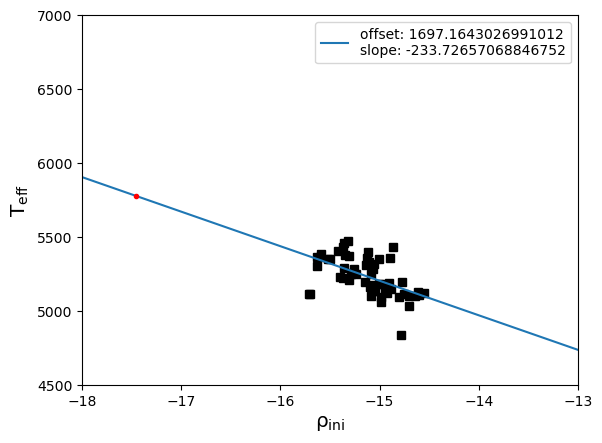

PyObject <matplotlib.legend.Legend object at 0x2b0fca41cf40>

In [113]:
plt.plot(log.(rho_success), teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm \rho_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(log.(rho_success)[mask], teff_t[mask], 1)
x = [-18.0:0.1:-13.0...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(-18,-13)
plt.ylim(4500,7000)

plt.plot([log(get_initial(t_success, rho_success, teff_t)[2])],[5778], color="red", marker=".")

plt.legend()

In [114]:
@info "Extrapolated (T,rho) = $(get_initial(t_success, rho_success, teff_t))"

┌ Info: Extrapolated (T,rho) = (14940.443588092769, 2.6138129873767868e-8)
└ @ Main In[114]:1
